<a href="https://colab.research.google.com/github/TobiaP/Minesweeper/blob/main/Minesweeper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MINESWEEPER

# Parameters



Here we can choose the parameters needed to build the board.

In [21]:
# Beginner 8x8 with 10 mines
# Intermediate 16x16 with 40 mines
# Expert 30x16 with 99 mines

HEIGHT = 4
WIDTH = 4
MINES = 4

# Initialization

Packages, images and mines initialization

In [22]:
%matplotlib inline

# Packages

!pip install --quiet python-sat[pblib,aiger]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import torch
from PIL import Image, ImageOps
import random
import sys
import requests
import urllib.request
from io import BytesIO
from pysat.solvers import Minisat22
from pysat.formula import CNF, CNFPlus
from pysat.card import *
import itertools



sys.setrecursionlimit(1500)

# Images
!git clone https://github.com/TobiaP/Minesweeper.git

img0 = Image.open('/content/Minesweeper/images/img0.png').resize((250, 250), Image.Resampling.LANCZOS)
img1 = Image.open('/content/Minesweeper/images/img1.svg').resize((250, 250), Image.Resampling.LANCZOS)
img2 = Image.open('/content/Minesweeper/images/img2.svg').resize((250, 250), Image.Resampling.LANCZOS)
img3 = Image.open('/content/Minesweeper/images/img3.svg').resize((250, 250), Image.Resampling.LANCZOS)
img4 = Image.open('/content/Minesweeper/images/img4.svg').resize((250, 250), Image.Resampling.LANCZOS)
img5 = Image.open('/content/Minesweeper/images/img5.svg').resize((250, 250), Image.Resampling.LANCZOS)
img6 = Image.open('/content/Minesweeper/images/img6.svg').resize((250, 250), Image.Resampling.LANCZOS)
img7 = Image.open('/content/Minesweeper/images/img7.svg').resize((250, 250), Image.Resampling.LANCZOS)
img8 = Image.open('/content/Minesweeper/images/img8.svg').resize((250, 250), Image.Resampling.LANCZOS)
imgmine = Image.open('/content/Minesweeper/images/imgmine.png').resize((250, 250), Image.Resampling.LANCZOS)
imgflag = Image.open('/content/Minesweeper/images/imgflag.png').resize((250, 250), Image.Resampling.LANCZOS)
imghidden = Image.open('/content/Minesweeper/images/imghidden.svg').resize((250, 250), Image.Resampling.LANCZOS)

# imgset = [imghidden for i in range(100)]

# shown board:
# -> 1 if cell is shown
# -> 0 if cell is hidden
# -> -1 if cell is a flag
board = [[0 for i in range(WIDTH)] for j in range(HEIGHT)]

# hidden board (complete with everithing)
hidboard = [[-1 for i in range(WIDTH)] for j in range(HEIGHT)]

# mines are distributed inside the board

mines = []
flags = []
hidden_mines = MINES

while len(mines) < MINES:
  newmine = [random.randrange(0, HEIGHT, 1),random.randrange(0, WIDTH, 1)]
  if newmine not in mines:
    mines.append(newmine)

fatal: destination path 'Minesweeper' already exists and is not an empty directory.


In [23]:
def cell_pos(y, x):
  return y*WIDTH + x

# Game

In [24]:
def write_hidboard():

  """
  Writes the global matrix hidboard according to the mines distribution
  """

  for i in range(HEIGHT):
    for j in range(WIDTH):
      minecount = 0

      if [i, j] in mines:
        hidboard[i][j] = -2
      else:
        if i!=0:
          if [i-1, j] in mines:
            minecount += 1
          if j!=0:
            if [i-1, j-1] in mines:
              minecount += 1
          if j!=WIDTH-1:
            if [i-1, j+1] in mines:
              minecount += 1
        if i!=HEIGHT-1:
          if [i+1, j] in mines:
            minecount += 1
          if j!=0:
            if [i+1, j-1] in mines:
              minecount += 1
          if j!=WIDTH-1:
            if [i+1, j+1] in mines:
              minecount += 1
        if j!=0:
          if [i, j-1] in mines:
            minecount += 1
        if j!=WIDTH-1:
          if [i, j+1] in mines:
            minecount += 1
        hidboard[i][j] = minecount

write_hidboard()

In [25]:
def Match_lost():

  """
  Prints the game over message.
  """
  print('\n\n //###########\\\ ')
  print(' || YOU LOST! ||')
  print(' \\\###########// \n\n')

def Match_won():

  """
  Prints the game won message.
  """
  print('\n\n //##########\\\ ')
  print(' || YOU WON! || ')
  print(' \\\##########// \n\n')

# Match_lost()
# Match_won()

In [26]:
def select_img(value):

  """

  Returns the image corresponding to the "value"

  Arguments:
  -> value: the value according to the hidboard or to the board corresponding to the image.

  """

  match value:
    case -1:
      return imghidden
    case 0:
      return img0
    case 1:
      return img1
    case 2:
      return img2
    case 3:
      return img3
    case 4:
      return img4
    case 5:
      return img5
    case 6:
      return img6
    case 7:
      return img7
    case 8:
      return img8
    case -2:
      return imgmine
    case 9:
      return imgflag

In [27]:
def get_board():

  """
  Overlaps the board and the hidboard and returns a vector made of images.

  Returns the board of images to be shown.
  """

  bshown = []
  for i in range(HEIGHT):
    for j in range(WIDTH):

      # shown element of hidden board
      if board[i][j] == 1:
        bshown.append(select_img(hidboard[i][j]))

      # hidden element
      elif board[i][j] == 0:
        bshown.append(select_img(-1))

      #flag element
      elif board[i][j] == -1:
        bshown.append(select_img(9))

  return bshown


#for i in range(HEIGHT):
  #for j in range(WIDTH):
    #board[i][j] = 1

# plot_game(get_board(), 3, 7)


In [28]:
def unveil(y, x):

  """
  Unveil the cell (y,x) and the cells near it,
  if they have to be unveiled.

  Arguments:
  -> y: the y coordinate of the cell
  -> x: the x coordinate of the cell
  """

  if x<0:
    return
  if y<0:
    return
  if y>=HEIGHT:
    return
  if x>=WIDTH:
    return
  if board[y][x] == 1 or board[y][x] == -1:
    return

  board[y][x] = 1

  if hidboard[y][x] < 0 or hidboard[y][x] >= 9:
    return


  if hidboard[y][x] == 0:
    unveil(y-1, x-1)
    unveil(y-1, x)
    unveil(y-1, x+1)
    unveil(y, x-1)
    unveil(y, x+1)
    unveil(y+1, x-1)
    unveil(y+1, x)
    unveil(y+1, x+1)

def click_board(y, x):

  """
  Checks if a mine is clicked, in this case :
  -> LOST = TRUE

  If the cell is not already revealed, unveil(cell).

  Arguments:
  -> y: the y coordinate of the cell
  -> x: the x coordinate of the cell
  """

  if [y, x] in mines:
    for i in range(HEIGHT):
      for j in range(WIDTH):
        board[i][j] = 1
    return True

  unveil(y, x)
  return False

def flag(y, x):

  """
  If the cell is not already revealed
  flag the cell.

  Arguments:
  -> y: the y coordinate of the cell
  -> x: the x coordinate of the cell
  """

  if board[y][x] == 0:
    board[y][x] = -1

    global hidden_mines
    hidden_mines = hidden_mines - 1
    flags.append([y, x])


In [29]:
# print the game
# imageset is the number

def plot_game(imageset, y_tile, x_tile):
  """
  Prints the number of unfound mines.
  Plots the matrix of images.
  the image in (y_tile, x_tile), which is the last clicke, is highlighted.

  Returns:
  True if lost
  """

  print("\n\n //#############\\\ ")
  print(" || MINES = ", hidden_mines, "||")
  print(" \\\#############// \n\n")

  fig, axes = plt.subplots(HEIGHT, WIDTH, figsize=(4,4))

  tile = []
  for i in range(len(x_tile)):
    tile.append(cell_pos(y_tile[i], x_tile[i]))

  for i,ax in enumerate(axes.flat):
    BORDER = 10
    if i in tile:
      img = imageset[i].copy()
      for x in range(img.width):
        for y in range(img.height - BORDER, img.height):
          img.putpixel((x, y), (0,255,255))
        for y in range(0, BORDER):
          img.putpixel((x, y), (0,255,255))
      for y in range(img.height):
        for x in range(0, BORDER):
          img.putpixel((x, y), (0,255,255))
        for x in range(img.width - BORDER, img.width):
          img.putpixel((x, y), (0,255,255))


      ax.imshow(img)
    else :
      ax.imshow(imageset[i])
    ax.axis('off')
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.show()


# Solution

In [30]:
def is_hidden(y, x):

  """
  Checks if a cell is hidden (and inside the Grid).
  Returns True if it is, False otherwise.

  Arguments:
  -> y: the y coordinate of the cell
  -> x: the x coordinate of the cell
  """

  if x<0:
    return False
  if y<0:
    return False
  if y>=HEIGHT:
    return False
  if x>=WIDTH:
    return False

  if board[y][x] == 0:
    return True
  else :
    return False

In [31]:
def is_number(y, x):

  """
  Checks if a cell is a number (and if it is inside the Grid).
  Returns True if it is, False otherwise.

  Arguments:
  -> y: the y coordinate of the cell
  -> x: the x coordinate of the cell
  """

  if x<0:
    return False
  if y<0:
    return False
  if y>=HEIGHT:
    return False
  if x>=WIDTH:
    return False

  if board[y][x] == 1 and hidboard[y][x]>0:
    return True
  else :
    return False

In [32]:
def is_flag(y, x):
  """
  Checks if a cell is a flag (and if it is inside the Grid).
  Returns True if it is, False otherwise.

  Arguments:
  -> y: the y coordinate of the cell
  -> x: the x coordinate of the cell
  """

  if x<0:
    return False
  if y<0:
    return False
  if y>=HEIGHT:
    return False
  if x>=WIDTH:
    return False

  if board[y][x] == -1:
    return True
  else :
    return False

In [33]:
def near(y, x):

  """
  Checks which cells around the cell are hidden and returns them.
  Returns the list of the near cells.

  Arguments:
  -> y: the y coordinate of the central cell
  -> x: the x coordinate of the central cell
  """

  near = []

  if(is_hidden(y-1, x-1)):
    near.append(cell_pos(y-1, x-1)+1)
  if(is_hidden(y-1, x)):
    near.append(cell_pos(y-1, x)+1)
  if(is_hidden(y-1, x+1)):
    near.append(cell_pos(y-1, x+1)+1)
  if(is_hidden(y, x-1)):
    near.append(cell_pos(y, x-1)+1)
  if(is_hidden(y, x+1)):
    near.append(cell_pos(y, x+1)+1)
  if(is_hidden(y+1, x-1)):
    near.append(cell_pos(y+1, x-1)+1)
  if(is_hidden(y+1, x)):
    near.append(cell_pos(y+1, x)+1)
  if(is_hidden(y+1, x+1)):
    near.append(cell_pos(y+1, x+1)+1)

  return near

In [34]:
def near_flags(y, x):

  """
  Checks how many flags are around the cell.
  Returns the number of flags.

  Arguments:
  -> y: the y coordinate of the central cell
  -> x: the x coordinate of the central cell
  """

  near_flags = 0

  if(is_flag(y-1, x-1)):
    near_flags = near_flags + 1
  if(is_flag(y-1, x)):
    near_flags = near_flags + 1
  if(is_flag(y-1, x+1)):
    near_flags = near_flags + 1
  if(is_flag(y, x-1)):
    near_flags = near_flags + 1
  if(is_flag(y, x+1)):
    near_flags = near_flags + 1
  if(is_flag(y+1, x-1)):
    near_flags = near_flags + 1
  if(is_flag(y+1, x)):
    near_flags = near_flags + 1
  if(is_flag(y+1, x+1)):
    near_flags = near_flags + 1

  return near_flags

In [35]:
def At_least(Gamma, lits, bound):

  """
  Computes the At least k value in CNF
  Returns the CNF value

  Arguments:
  - lits:list of literals
  - bound: k for At least k
  """

  num_elements = len(lits) - bound + 1

  for least in list(itertools.combinations(lits, num_elements)):
    Gamma.add_clause(least)

#At_least([1,2,3,4,5], 3)

In [36]:
def At_most(Gamma, lits, bound):

  """
  Computes the At most k value in CNF
  Returns the CNF value

  Arguments:
  - lits:list of literals
  - bound: k for At most k
  """

  num_elements = bound + 1

  for most in list(itertools.combinations(lits, num_elements)):
    Gamma.add_clause([-x for x in most])

# At_most([1,2,3,4,5], 3)

In [37]:
def equals(Gamma, lits, bound):
  """
  Computes the equals k value in CNF
  Returns the CNF value

  Arguments:
  - lits:list of literals
  - bound: k for equals k
  """

  At_least(Gamma, lits, bound)
  At_most(Gamma, lits, bound)

# equals([1,2,3,4,5], 3)

In [38]:

def build_CNF(Gamma):

  """
  builds the CNF formula for the S1,S2,S3,S4.
  S0: AND(for every number) S1 and S2 : exactly m mines around every numbered element
  S3: S4 and S5 : exactly M mines in the whole board
  Return the CNF formula for S0 and S3.
  """


  S = []

  #### S0 ####

  for i in range(HEIGHT):
    for j in range(WIDTH):

      if is_number(i, j) and len(near(i,j))>0:
        equals(Gamma, near(i, j), (hidboard[i][j]-near_flags(i, j)))


  #### S3 ####

  hidden_list = []
  for i in range(HEIGHT):
    for j in range(WIDTH):
      if is_hidden(i, j):
        hidden_list.append(cell_pos(i, j)+1)

  global hidden_mines
  equals(Gamma, hidden_list, hidden_mines)

# click_board(3, 3)
# plot_game(get_board(), 3, 3)
# formula = build_CNF()
# print(formula)


In [39]:
def choose_start( how="0"):

  """
  Choses the starting point:
  -> 0 : first cell with 0 value
  -> otherwise : random choice

  Arguments:
  -> how: string "0" or other.

  Returns:
  x -> the x coordinate of the cell
  y -> the y coordinate of the cell
  """

  if how=="0":
    for i in range(HEIGHT):
      for j in range(WIDTH):
        if hidboard[i][j] == 0:
          return [i,j]
    return [random.randrange(0, HEIGHT, 1),random.randrange(0, WIDTH, 1)]
  else:
    return [random.randrange(0, HEIGHT, 1),random.randrange(0, WIDTH, 1)]

In [40]:
def solve():


  found_mines = []
  found_free = []

  plot_game(get_board(), [-1], [-1])
  start = choose_start()
  y_start = start[0]
  x_start = start[1]
  click_board(y_start, x_start)
  plot_game(get_board(), [y_start], [x_start])
  LOST = False
  WON = False

  while not LOST and not WON:

    Gamma = Minisat22()
    build_CNF(Gamma)

    certainty = False

    y_last = []
    x_last = []

    print("\n\nWe are assuming each cell to not be a mine and using SAT to verify which one is surely a MINE\n")

    for i in range(HEIGHT):
      for j in range(WIDTH):
        if is_hidden(i, j):
          if Gamma.solve(assumptions=[-(cell_pos(i, j)+1)])==False:
              certainty = True
              flag(i,j)

              if([i,j] not in mines):
                Match_lost()
                return


    if certainty==False:
      print("\nAll models resulted SAT so we are not sure!")
    else:
      plot_game(get_board(), [-1], [-1])
      print("\nWe are sure that all these cells are MINES so they are flagged\n\n")

    if hidden_mines == 0:
      for m in mines:
        if m not in [f for f in flags]:
          Match_lost()
          return
      Match_won()
      return

    print("\n\nWe are assuming each cell to be a mine and using SAT to verify which one is surely NOT A MINE\n")

    for i in range(HEIGHT):
      for j in range(WIDTH):
        if is_hidden(i, j):
          if Gamma.solve(assumptions=[(cell_pos(i, j)+1)])==False:
              certainty = True
              LOST = click_board(i, j)
              y_last.append(i)
              x_last.append(j)


    if certainty==False:
      print("\nAll models resulted SAT so we are not sure!")
    else:
      plot_game(get_board(), y_last, x_last)
      print("\nWe are sure that all these cells are NOT MINES!\n\n")

    if hidden_mines == 0:
      Match_won()
      return

    if LOST:
      Match_lost()
      return


    if certainty==False:

      print("\n\n\nUsing SAT all models resulted sat, so we are not sure of which cell is or is not a mine!\n")

      print("\nWe are using WMC to calculate every possible model, then we will calculate the probability for every cell to NOT be a MINE\n")

      free_cells = []
      for i in range(HEIGHT):
        for j in range(WIDTH):
          if not is_hidden(i, j):
            free_cells.append(-(cell_pos(i, j)+1))


      numberofcells = HEIGHT*WIDTH
      models = []
      for model in Gamma.enum_models(assumptions=free_cells):
        models.append(model[:numberofcells])
      total_models_sat = [0 for i in range(numberofcells)]

      for model in models:
        for l in model:
          this_x = (abs(l)-1)%WIDTH
          this_y = (abs(l)-1)//WIDTH
          if is_hidden(this_y, this_x):
            if l>0:
              total_models_sat[l-1] = total_models_sat[l-1] + 1
          else:
            total_models_sat[abs(l)-1] = total_models_sat[abs(l)-1] + 1

      total_models = len(models)
      best_choice = min(total_models_sat)
      best_probability = best_choice/total_models

      best_cell_pos = total_models_sat.index(best_choice)

      best_x = (best_cell_pos)%WIDTH
      best_y = (best_cell_pos)//WIDTH

      LOST = click_board(best_y, best_x)
      plot_game(get_board(), [best_y], [best_x])

      print("\nWe have chosen the cell " + str(best_y) + " " + str(best_x) + " because it had the lowest probability of being a MINE : " + str(best_probability))

      if hidden_mines == 0:
        Match_won()
        return

      if LOST:
        Match_lost()
        return


    Gamma.delete()

# RUN



 //#############\\ 
 || MINES =  4 ||
 \\#############// 




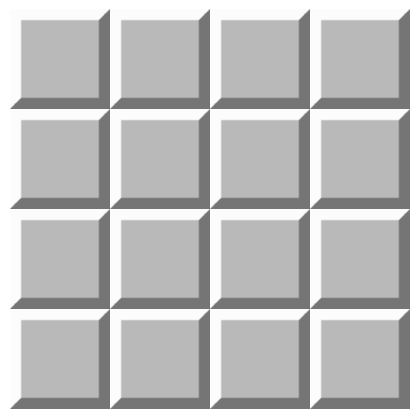



 //#############\\ 
 || MINES =  4 ||
 \\#############// 




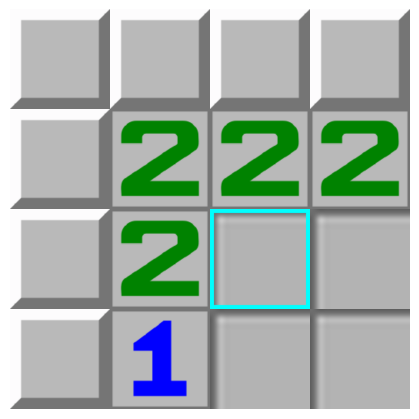



We are assuming each cell to not be a mine and using SAT to verify which one is surely a MINE



 //#############\\ 
 || MINES =  0 ||
 \\#############// 




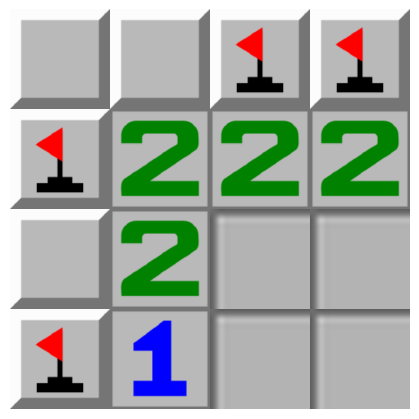


We are sure that all these cells are MINES so they are flagged




 //##########\\ 
 || YOU WON! || 
 \\##########// 




In [41]:
solve()